# RBF Neural Network

### Importing Libraries

In [1]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Data Preparation

In [2]:
# Generating 441 random points

data = list()
for i in range(0, 21):
    for j in range(0, 21):
        x1 = (i * 0.2) - 2
        x2 = (j * 0.2) - 2
        data.append([x1, x2])

np.random.seed(2) # To fix the value each time
np.random.shuffle(data)

- <font size="3"> Randomly generated 441 datapoints, where -2 < x1 < 2 and -2 < x2 < 2, as given in the question. </font>

In [3]:
# Generating bipolar(-1/1) labels for data

count1 = 0
count2 = 0
data_labels = list()

for i in data:
    value = (i[0] * i[0]) + (i[1] * i[1])
    if value <= 1:
        data_labels.append([i[0], i[1], 1])
        count1 = count1 + 1
    else:
        data_labels.append([i[0], i[1], -1])
        count2 = count2 + 1

print('Datapoints on or inside circle (label +1) are :', count1)
print('Datapoints outside circle (label -1) are :', count2)
data_labels = np.array(data_labels)
print('Shape of data with labels :', data_labels.shape)

Datapoints on or inside circle (label +1) are : 77
Datapoints outside circle (label -1) are : 364
Shape of data with labels : (441, 3)


- <font size="3"> Assigned labels for all datapoints, such that we get non-linearlly separable pattern (circle), where radius = 1. Datapoints inside circle are having label +1 and outside are having label -1.</font>

## Plots

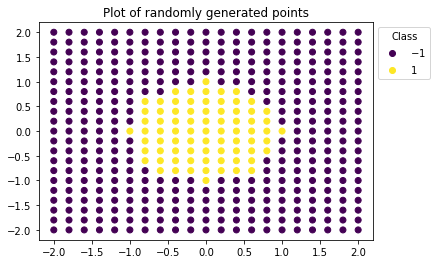

In [4]:
# Visualization of generated points

p = plt.scatter(data_labels[:, 0], data_labels[:, 1], c=data_labels[:, 2])
plt.legend(*p.legend_elements(prop='colors'), loc="best", title="Class", bbox_to_anchor=(1, 1))
plt.title("Plot of randomly generated points")
plt.show()

## Splitting data into train and test sets

In [5]:
ratio = 0.20
total_data = len(data_labels)
split_index = int(total_data*ratio)

train = data_labels[split_index:]
test = data_labels[:split_index]
print('Train data :', len(train))
print('Test data :', len(test)) 

Train data : 353
Test data : 88


- <font size="3"> Splitted data into train and test sets, took 20% of data for testing and remaining for training.</font> 

### Train set

In [6]:
X_train = train[:, :2]
y_train = train[:, 2:]

print(X_train.shape)
print(y_train.shape)

(353, 2)
(353, 1)


### Test set

In [7]:
X_test = test[:, :2]
y_test = test[:, 2:]

print(X_test.shape)
print(y_test.shape)

(88, 2)
(88, 1)


## Functions' Definition


- <font size="4"> **Gaussian function** : </font> <br/> &nbsp;
    - <font size="3"> Kernel is a way of placing a data space into a higher dimensional vector space so that the intersections of the data space with hyperplanes in the higher dimensional space determine more complicated, curved decision boundaries in the data space. </font> <br/> &nbsp;
    - <font size="3"> The Gaussian kernel transforms the dot product in the infinite dimensional space into the Gaussian function of the distance between points in the data space: If two points in the data space are nearby then the angle between the vectors that represent them in the kernel space will be small. If the points are far apart then the corresponding vectors will be close to “perpendicular”.</font> <br/>&nbsp;
    
- <font size="4"> **Mean-squared error** : </font> <br/> &nbsp;
    - <font size="3"> The mean squared error (MSE) tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. The squaring is necessary to remove any negative signs.</font> <br/> &nbsp;
    - <font size="3"> MSE is used to check how close estimates or forecasts are to actual values. Lower the MSE, the closer is forecast to actual.</font> <br/> &nbsp;

In [8]:
# Euclidean Distance between two points
def euclidean_dist(x1, x2):
    return sum([(a - b) ** 2 for a, b in zip(x1, x2)])


# Evaluating the Gaussian Function
def gaussian(distance, sig):
    return math.exp((-1) * (distance) / ((2) * (sig ** 2)))


# Evaluating the Gaussian Matrix
def calculateMatrix(data, centers, sig):
    outputMatrix = np.zeros((len(data), len(centers)))
    for i in range(len(data)):
        for j in range(len(centers)):
            outputMatrix[i][j] = gaussian(euclidean_dist(data[i], centers[j]), sig)
    return outputMatrix


# Evaluating mean-squared error
def mse(y_actual, y_prediction):
    err = 0
    for i in range(len(y_actual)):
        err = err + ((y_actual[i] - y_prediction[i]) ** 2)
    return (err / len(y_actual))


# Evaluating accuracy
def accuracy(actual, prediction):
    count = 0
    n = len(actual)
    if n == 0:
        return 0
    for i in range(n):
        if (actual[i] == 1 and prediction[i] >= 0) or (actual[i] == -1 and prediction[i] < 0):
            count = count + 1
    return (count / n)


# Generating graph
def sigma_plot(sigma, train, test, title):
    plt.plot(sigma, train, 'b', label = "Train Accuracy")
    plt.plot(sigma, test, 'r', label = "Test Accuracy")
    plt.title(title)
    plt.xlabel("Spread Parameter (sigma)")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

## Training neural network

- <font size="3"> In RBF, first transform all input data to radial basis non-linear function (Gaussian kernel in our case), and then apply linear transformation to find output. </font> <br/>
- <font size="3"> Increase dimensions with help of radial basis functions, to easily separate non-linearlly separable data in higher dimension. </font> <br/>
- <font size="3"> Output of kernel functions then used to find weights. </font> <br/>
- <font size="3"> Dot product between weights and radial function's outputs gives predicted output. </font> <br/>

In [9]:
def neural_network(data, y_train, centers, test, sigma_list): 
    
    error_train_list = list()
    error_test_list = list()
    acc_train_list = list()
    acc_test_list = list()
    
    for sigma in sigma_list:
        
        G = calculateMatrix(data, centers, sigma)
        Ginv = np.linalg.pinv(G)
        W = Ginv.dot(y_train) # Calculating W using closed form
        y_pred_train = G.dot(W) # Predicting on the training data
        
        # Predicting on the test data.
        g = calculateMatrix(test, centers, sigma)
        y_pred_test = g.dot(W)
        
        # Calculating errors and accuracy for both training and testing results.
        error_train = mse(y_train, y_pred_train)
        error_test = mse(y_test, y_pred_test)
        acc_train = accuracy(y_train, y_pred_train)
        acc_test = accuracy(y_test, y_pred_test)
        
        error_train_list.append(error_train)
        error_test_list.append(error_test)
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        
    return np.array(error_train_list), np.array(error_test_list), np.array(acc_train_list), np.array(acc_test_list)

In [10]:
sigma = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 50]

## Question-1 : Using all the points in the Training Set as Centers

In [11]:
trainErr1, testErr1, trainAcc1, testAcc1 = neural_network(X_train, y_train, X_train, X_test, sigma)

In [12]:
dash = '-' * 85
print(dash)
print('{:<10s}{:<20s}{:<20s}{:<20s}{:<20s}'.format('Sigma', 'Training Error','Test Error','Train Accuracy','Test Accuracy'))
print(dash)
        
for i in range(len(trainErr1)):
    print('{:<10.2f}{:<20.5f}{:<20.5f}{:<20.5f}{:<20.5f}'.format(sigma[i], trainErr1[i][0], testErr1[i][0], trainAcc1[i], testAcc1[i]))

-------------------------------------------------------------------------------------
Sigma     Training Error      Test Error          Train Accuracy      Test Accuracy       
-------------------------------------------------------------------------------------
0.01      0.00000             1.00000             1.00000             1.00000             
0.05      0.00000             0.99813             1.00000             0.97727             
0.10      0.00000             0.47073             1.00000             0.97727             
0.20      0.00000             0.20126             1.00000             0.95455             
0.25      0.00000             0.35778             1.00000             0.90909             
0.30      0.00000             0.64407             1.00000             0.88636             
0.50      0.00000             938.96233           1.00000             0.62500             
0.75      0.02764             114.10741           0.99717             0.86364             
1.00     

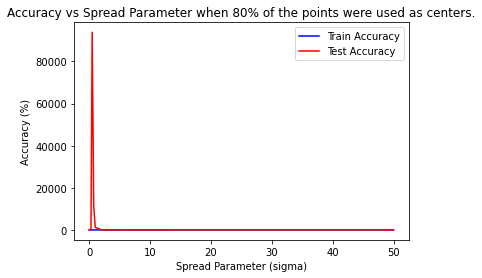

In [13]:
sigma_plot(sigma, trainErr1 * 100, testErr1 * 100, "Accuracy vs Spread Parameter when 80% of the points were used as centers.")

- <font size="4"> If sigma is very small </font> <br/> &nbsp;
    - <font size="3"> When the sigma value is small the Gaussian function is very small so the function of different centers will not overlap with each other. Thus, the accuracy is high for training set only when the spread parameter is small.</font> <br/> &nbsp;
- <font size="4"> If sigma is very large </font> <br/> &nbsp;
    - <font size="3"> When the value of spread parameter increases the Gaussian function increases as well , thus it will overlap different center functions. So , accuracy decreases as the sigma value increases. After one point, when the centers of Gaussian functions is stop updating the accuracy will attain constant value.</font> <br/> &nbsp;

- <font size="3"> We are using all training data as centers, which will overfit the data and fail to generalize on test set when sigma is very small. <br/> &nbsp;
 </font>

### Best spread parameter(Sigma) : 5

## Question-2(a) : Using randomly 150 points from the dataset as centers

In [14]:
np.random.seed(2)

centers = np.copy(train)
np.random.shuffle(centers)
centers_shuffled = centers[:150]
print('Dimension of new centers:', centers_shuffled.shape)

Dimension of new centers: (150, 3)


In [15]:
X_random = centers_shuffled[:, :2]
y_random = centers_shuffled[:, 2:]
print(X_random.shape, y_random.shape)

(150, 2) (150, 1)


In [16]:
trainErr2, testErr2, trainAcc2, testAcc2 = neural_network(X_train, y_train, X_random, X_test, sigma)

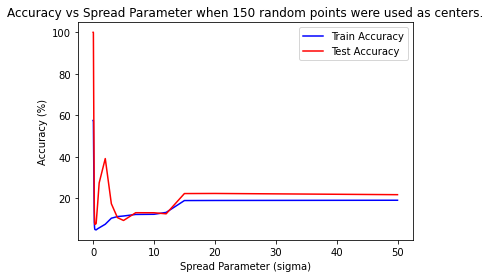

In [17]:
sigma_plot(sigma, trainErr2 * 100, testErr2 * 100, "Accuracy vs Spread Parameter when 150 random points were used as centers.")

- <font size="3"> When centers are selected using random initialization, the model randomly select the centers for Gaussian functions from the training data-points. So there a possibility that the model will reach the local optimum and won't be able to converge to the global optimum, thus the model shows large variation. </font>

### Best spread parameter(Sigma) : 5

## Question-2(b) : Using KMeans clustering to get 150 centroids

In [18]:
classifier = KMeans(n_clusters = 150, random_state = 42)
classifier.fit(X_train)
X_centers = classifier.cluster_centers_
X_centers.shape

(150, 2)

In [19]:
trainErr3, testErr3, trainAcc3, testAcc3 = neural_network(X_train, y_train, X_centers, X_test, sigma)

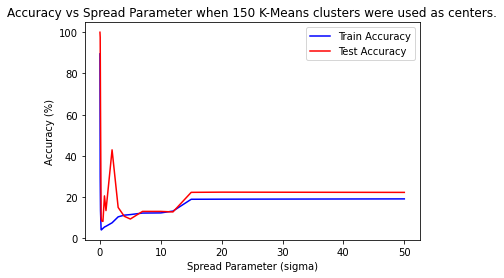

In [20]:
sigma_plot(sigma, trainErr3 * 100, testErr3 * 100, "Accuracy vs Spread Parameter when 150 K-Means clusters were used as centers.")

- <font size="3">  When the center is selected using K-means, the center values are random and not selected from the training data-points, thus the model won't be able to easily classify the datapoint. </font>

### Best spread parameter(Sigma) : 5

## Comparison between both methods

- <font size="3"> If the distance between x and x' is much larger than sigma, the kernel function tends to be zero. Thus, if the sigma is very small, only the x within the certain distance can affect the predicting point. In other words, smaller sigma tends to make a local classifier, larger sigma tends to make a much more general classifier. </font> <br/> &nbsp;
- <font size="3"> As for the variance and bias, smaller sigma tends to be less bias and more variance while larger sigma tends to be less variance and more bias. </font> <br/> &nbsp;
- <font size="3"> Our explanation is consistent with the example above. When sigma=5, the decision boundary is a general one considering nearly all of the data points and because of this, the decision boundary is very smooth. While the decision boundary for sigma=0.25 is very strict. </font> <br/> &nbsp;


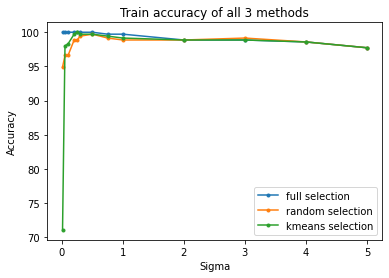

In [21]:
# Training Accuracy Plot
plt.plot(sigma[:13], trainAcc1[:13]*100, marker='.', label="full selection")
plt.plot(sigma[:13], trainAcc2[:13]*100, marker='.', label="random selection")
plt.plot(sigma[:13], trainAcc3[:13]*100, marker='.', label="kmeans selection")

plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.title('Train accuracy of all 3 methods')
plt.legend()
plt.show()

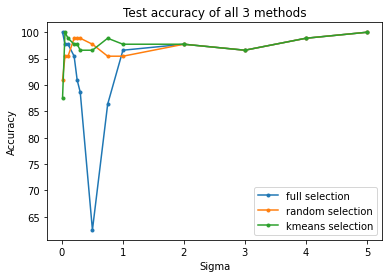

In [22]:
# Test Accuracy Plot
plt.plot(sigma[:13], testAcc1[:13]*100, marker='.', label="full selection")
plt.plot(sigma[:13], testAcc2[:13]*100, marker='.', label="random selection")
plt.plot(sigma[:13], testAcc3[:13]*100, marker='.', label="kmeans selection")

plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.title('Test accuracy of all 3 methods')
plt.legend()
plt.show()

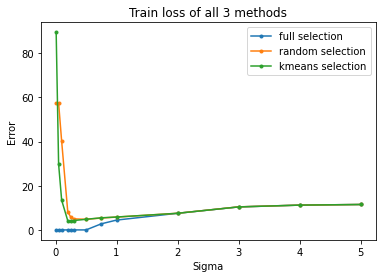

In [23]:
# Training Error Plot
plt.plot(sigma[:13], trainErr1[:13]*100, marker='.', label="full selection")
plt.plot(sigma[:13], trainErr2[:13]*100, marker='.', label="random selection")
plt.plot(sigma[:13], trainErr3[:13]*100, marker='.', label="kmeans selection")

plt.xlabel('Sigma')
plt.ylabel('Error')
plt.title('Train loss of all 3 methods')
plt.legend()
plt.show()

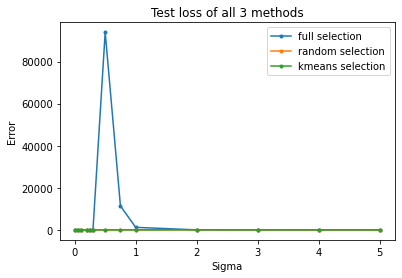

In [24]:
# Test Error Plot
plt.plot(sigma[:13], testErr1[:13]*100, marker='.', label="full selection")
plt.plot(sigma[:13], testErr2[:13]*100, marker='.', label="random selection")
plt.plot(sigma[:13], testErr3[:13]*100, marker='.', label="kmeans selection")

plt.xlabel('Sigma')
plt.ylabel('Error')
plt.title('Test loss of all 3 methods')
plt.legend()
plt.show()

- <font size="3"> When the centers are selected from all train set data-points, the model first overfits the data and then as the spread parameter value increases performance of the model gets stable. </font> <br/> &nbsp; 
- <font size="3"> When the centers are randomly initialized from train set, the model overfits the data, which means the models fail to generalize on unknown data. </font> <br/> &nbsp;
- <font size="3"> When the centers are selected with K-means method, accuracy is very low for small values of spread parameter, and eventually gets improved. </font> <br/> &nbsp;